# MANGO Imager Tutorial

This notebook presents examples of how to download and perform basic plotting of MANGO airglow data.

Scan to go to GitHub repo: <img src="https://go.ece.illinois.edu/qr/CEDAR2024MANGOtutorial.png?rn=0613T123559" width="200">

## Setup
### Imports

In [9]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import subprocess
import h5py
from scipy.signal import medfilt2d
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import requests

### Define Site and Date

In [10]:
site = 'blo'
emission = 'green'
date = datetime.datetime(2023,5,11)
#asi_directory = '/home/airglow/scratch_data/CEDAR_test/MANGO_Data'
asi_directory = 'MANGO_Data'

### Helper Functions

In [11]:
def download_hdf5_files(url, save_dir):
    """
    Download all .hdf5 files from a given URL and save them to a specified directory.

    :param url: The URL of the web page to scrape for .hdf5 files.
    :param save_dir: The directory where the files will be saved.
    :return: List of paths to the downloaded files.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Get the HTML content of the page
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all links to .hdf5 files
    hdf5_links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        if href.endswith('.hdf5'):
            hdf5_links.append(urljoin(url, href))

    # Download each .hdf5 file
    downloaded_files = []
    for hdf5_url in hdf5_links:
        filename = os.path.basename(hdf5_url)
        file_path = os.path.join(save_dir, filename)
        
        # Download the file
        hdf5_response = requests.get(hdf5_url, stream=True)
        hdf5_response.raise_for_status()  # Raise an error for bad status codes

        with open(file_path, 'wb') as file:
            for chunk in hdf5_response.iter_content(chunk_size=8192):
                file.write(chunk)
        
        downloaded_files.append(file_path)

    return downloaded_files

def download_mango_L1(site, emission, date, asi_directory=None):
    """
    Download MANGO L1 data for a specific site, emission, and date.

    Parameters:
    site (str): MANGO site abbreviation (e.g., "low").
    emission (str): Emission type ('green' or 'red').
    date (datetime): Date of interest.
    asi_directory (str): Directory to download data to. Defaults to the current directory.

    Returns:
    list: List of paths to the downloaded files.
    """
    downloaded_files = []

    if asi_directory is None:
        asi_directory = './'

    emission_path = 'greenline' if emission == 'green' else 'redline'
    target_directory = os.path.join(asi_directory, site, str(date.year), date.strftime('%j'))
    url = f'https://data.mangonetwork.org/data/transport/mango/archive/{site}/{emission_path}/level1/{date.year}/{date.strftime("%j")}/'
    
    downloaded_files = download_hdf5_files(url, target_directory)
    
    print(url)
    print(target_directory)

    return downloaded_files

def load_hdf5_to_xarray(file_path, kernel_size=7):
    """
    Load data from an HDF5 file into an xarray Dataset and apply a median filter to image data.

    Parameters:
    file_path (str): Path to the MANGO HDF5 file.
    kernel_size (int): Size of the 2D median filter to apply to each image. Defaults to 7.

    Returns:
    xarray.Dataset: Dataset containing the loaded data.
    """
    data_arrays = {}
    with h5py.File(file_path, 'r') as hdf:
        for key in hdf.keys():
            if isinstance(hdf[key], h5py.Dataset):
                data_arrays[key] = xr.DataArray(hdf[key][...], name=key)

    # Convert Unix times to datetime objects
    unix_times_start = data_arrays['UnixTime'][0].values
    start_times = pd.to_datetime(unix_times_start, unit='s', utc=True)

    unix_times_stop = data_arrays['UnixTime'][1].values
    stop_times = pd.to_datetime(unix_times_stop, unit='s', utc=True)

    # Calculate integration time and ensure it's a float
    integration_time_values = (stop_times - start_times).total_seconds()
    integration_time_values = integration_time_values.astype(float)

    # Ensure 'time' is numpy.datetime64
    start_times_np = np.array(start_times, dtype='datetime64[ns]')

    # Rename the dimensions of the ImageData
    image_data = data_arrays['ImageData'].rename({'dim_0': 'time', 'dim_1': 'north', 'dim_2': 'east'})
    image_data.attrs['description'] = 'Pixel values of image at each time step'

    # Process other variables
    azimuth = data_arrays['Azimuth'].rename({'dim_0': 'north', 'dim_1': 'east'})
    azimuth.attrs['units'] = 'Degrees'
    azimuth.attrs['description'] = 'Azimuth of each pixel'
    elevation = data_arrays['Elevation'].rename({'dim_0': 'north', 'dim_1': 'east'})
    elevation.attrs['units'] = 'Degrees'
    elevation.attrs['description'] = 'Elevation of each pixel'
    latitude = data_arrays['Latitude'].rename({'dim_0': 'north', 'dim_1': 'east'})
    latitude.attrs['units'] = 'Degrees N'
    latitude.attrs['description'] = 'Geodetic latitude of each pixel'
    longitude = data_arrays['Longitude'].rename({'dim_0': 'north', 'dim_1': 'east'})
    longitude.attrs['units'] = 'Degrees E'
    longitude.attrs['description'] = 'Geodetic longitude of each pixel'
    CCDTemperature = data_arrays['CCDTemperature'].rename({'dim_0': 'time'})
    CCDTemperature.attrs['units'] = 'Celsius'
    CCDTemperature.attrs['description'] = 'Temperature of CCD'

    north_array = xr.DataArray(data_arrays['PixelCoordinates'][0][0, :], dims=('north'))
    north_array.attrs['units'] = 'km'
    north_array.attrs['description'] = 'Distance in north direction from site at airglow layer'
    east_array = xr.DataArray(data_arrays['PixelCoordinates'][1][:, 0], dims=('east'))
    east_array.attrs['units'] = 'km'
    east_array.attrs['description'] = 'Distance in east direction from site at airglow layer'

    # Apply median filter to each image
    im_ds = []
    for id in image_data:
        temp = xr.DataArray(medfilt2d(id, kernel_size=kernel_size), dims=('north', 'east'))
        im_ds.append(temp)

    combined = xr.concat(im_ds, dim='time')
    combined.attrs['description'] = 'Pixel values of image at each time step after median filter'

    integration_time = xr.DataArray(integration_time_values, coords={'time': start_times_np}, dims=('time'))
    integration_time.attrs['units'] = 's'
    integration_time.attrs['description'] = 'Integration time of the image'

    # Create xarray Dataset
    ds = xr.Dataset({
        'integration_time': integration_time,
        'ImageData': combined,
        'Azimuth': azimuth,
        'Elevation': elevation,
        'Latitude': latitude,
        'Longitude': longitude,
        'CCDTemperature': CCDTemperature,
        'east': east_array,
        'north': north_array
    })

    return ds


## Download and Load Data

In [12]:
downloaded_data = download_mango_L1(site,emission,date,asi_directory=asi_directory)

https://data.mangonetwork.org/data/transport/mango/archive/blo/greenline/level1/2023/131/
MANGO_Data/blo/2023/131


In [13]:
# ds is our dataset
ds = {}
ds[site] = load_hdf5_to_xarray(downloaded_data[0])

### Examine the loaded dataset
The dataset is an xarray data structure containing information from the HDF5 file and has the following format:

Coordinates:
* time (datetime64) - time stamps of each image in the data set
* east (float) - east km distance from the center of the image. This is a uniform step.
* north (float) - north km distance from the center of the image. This is a uniform step.

Data Variable:
* integration_time (float) - integration time for each image in sec (dim: time)
* ImageData (int) - intensity values in the image (dims: time, north, east)
                  the image data has had a 7x7 median filter applied to remove stars
* Azimuth (float) - azimuth for each pixel, in deg (dims: north, east)
* Elevation (float) - elevation for each pixel, in deg (dims: north, east)
* Latitude (float) - latitude for each pixel, in deg N (dims: north, east)
* Longitude (float) - longtitude for each pixel, in deg E (dims: north, east)
* CCDTemperature (float) - CCD temperature, in C (dim: time)

In [14]:
ds['blo']

<xarray.Dataset> Size: 51MB
Dimensions:           (time: 173, north: 500, east: 500)
Coordinates:
  * time              (time) datetime64[ns] 1kB 2023-05-11T04:30:00 ... 2023-...
  * east              (east) float64 4kB -324.3 -323.0 -321.7 ... 323.0 324.3
  * north             (north) float64 4kB -324.3 -323.0 -321.7 ... 323.0 324.3
Data variables:
    integration_time  (time) float64 1kB 110.0 110.0 110.0 ... 110.0 110.0 110.0
    ImageData         (time, north, east) uint8 43MB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    Azimuth           (north, east) float64 2MB -135.0 -135.1 ... 44.88 45.0
    Elevation         (north, east) float64 2MB 9.749 9.776 ... 9.776 9.749
    Latitude          (north, east) float64 2MB 39.0 39.0 39.0 ... 44.74 44.74
    Longitude         (north, east) float64 2MB -115.1 -115.1 ... -107.4 -107.4
    CCDTemperature    (time) float64 1kB -4.95 -4.71 -5.35 ... -4.95 -5.27 -4.95

## Visualize Data
The xarray format allows easy manipulation and plotting of the data

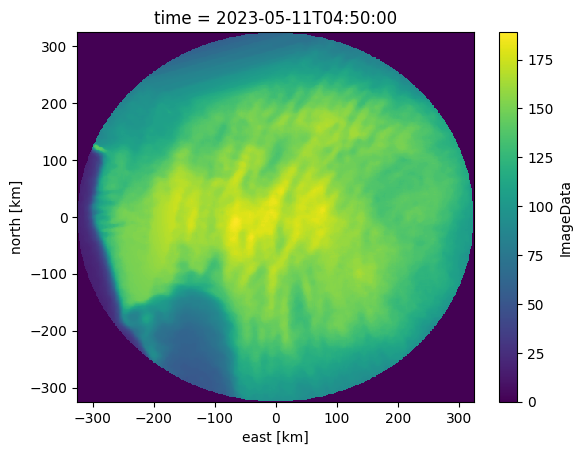

In [15]:
ds['blo'].ImageData.isel(time=10).plot()

### Geodetic Grid

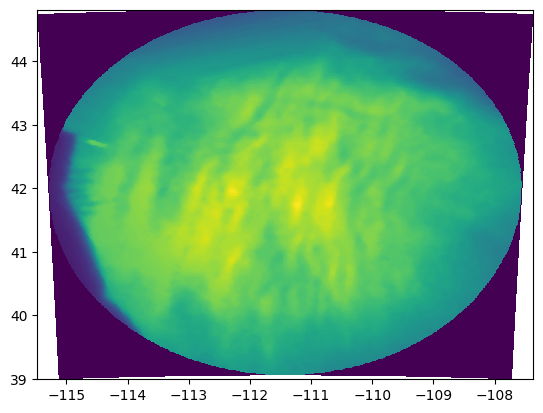

In [16]:
plt.pcolormesh(ds['blo'].Longitude,ds['blo'].Latitude,ds['blo'].ImageData[0])

### Masks Low-Elevations

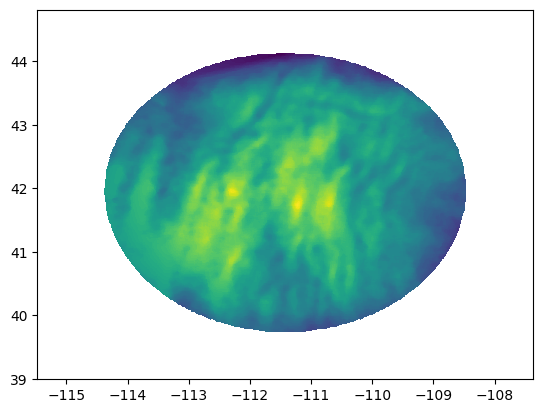

In [17]:
mask = ds['blo'].Elevation > 20.
plt.pcolormesh(ds['blo'].Longitude,ds['blo'].Latitude,ds['blo'].ImageData[0].where(mask))

### Intensity over Time
Plot intensity as a function of time of the highest elevation beams

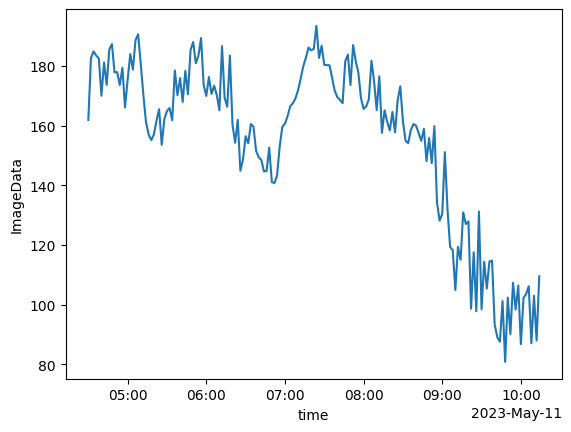

In [18]:
ze_mask = ds['blo'].Elevation > 85
ds['blo'].ImageData.where(ze_mask).mean(dim=['east','north']).plot()

### Sub-Images

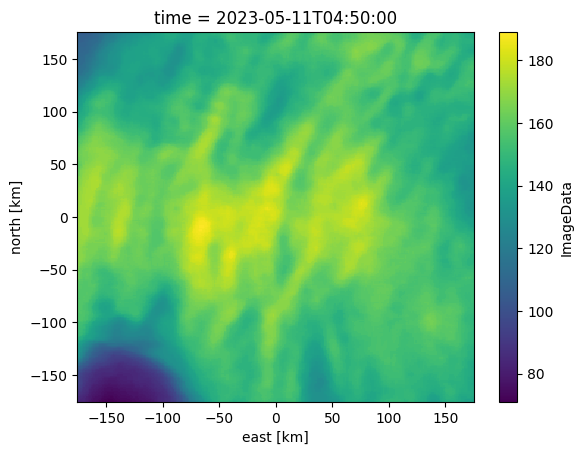

In [19]:
# Find the square inscribed in the circle. The side of the square that can be inscribed
# in a circle of radius r is sqrt(2)*r. Find the smallest dimension in the east and north
# arrays and use that as the radius. May need to tweak this for imagers that have obstructions
# above el_cutoff
min_r = np.min([np.abs(ds['blo'].east.where(mask)).max(),np.abs(ds['blo'].north.where(mask)).max()])
r = np.floor(np.sqrt(2)*min_r/2.)
subset = ds['blo'].sel(east=slice(-r,r), north=slice(-r,r))
subset.isel(time=10).ImageData.plot()

## Extract Waves

### Filter Data

In [20]:
import scipy.signal as signal
import multiprocessing as mp

# Calculate the sampling period (in seconds)
sampling_periods = pd.to_timedelta(ds['blo'].time.diff(dim='time').values.mean()).total_seconds()

# Desired filter parameters
ntaps = 13
Tlo = 2   # minutes
Thi = 20  # minutes

# Design the filter
fs = 1./sampling_periods
cutofflo = 1./(Thi*60.)
cutoffhi = 1./(Tlo*60.)
fir_coeff = signal.firwin(ntaps, [cutofflo], pass_zero=False, fs=fs)

# Function to apply the filter to a subset of the data
def apply_filter(sub_data):
    return signal.filtfilt(fir_coeff, 1.0, sub_data, axis=0)

# Split the data for parallel processing
def parallel_filter(ds, var_name, n_jobs=mp.cpu_count()//2):
    data = ds[var_name].values
    shape = data.shape
    
    # Reshape data to apply filter independently on each (north, east) pair
    reshaped_data = data.reshape(shape[0], -1)
    
    # Use multiprocessing to filter data in parallel
    with mp.Pool(processes=n_jobs) as pool:
        filtered_data = pool.map(apply_filter, [reshaped_data[:, i] for i in range(reshaped_data.shape[1])])
    
    # Combine the filtered data back into the original shape
    filtered_data = np.array(filtered_data).T.reshape(shape)
    
    # Create a new xarray Dataset with the filtered data
    ds['FilteredImageData'] = (('time', 'north', 'east'), filtered_data)
    
    return ds

# # IF USING MULTIPROCESSING
# # Apply the parallel filter
# ds['blo'] = parallel_filter(ds['blo'], 'ImageData')

# IF NOT USING MULTIPROCESSING
# Apply the FIR filter using filtfilt to avoid time offset
filtered_data = signal.filtfilt(fir_coeff, 1.0, ds['blo'].ImageData, axis=0)
ds['blo']['FilteredImageData'] = (('time','north','east'), filtered_data)

### Display the Filtered Data

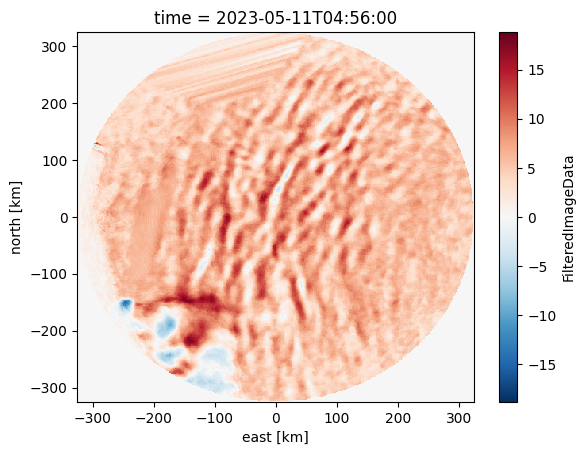

In [21]:
ds['blo'].FilteredImageData.isel(time=13).plot()

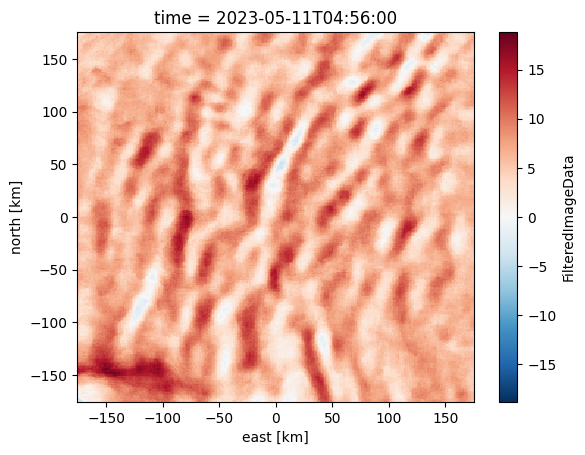

In [22]:
subset = ds['blo'].sel(east=slice(-r,r), north=slice(-r,r))
subset.isel(time=13).FilteredImageData.plot()

In [23]:
import ipywidgets as widgets
from ipywidgets import interact

background_subtract = subset.FilteredImageData - subset.FilteredImageData.mean(dim=['east','north'])

# Function to update the plot
def update_plot(time_index):
    background_subtract.isel(time=time_index).plot(vmin=-15, vmax=15, cmap='bwr')

# Create an interactive widget
interact(update_plot, time_index=widgets.IntSlider(min=0, max=len(subset.time)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='time_index', max=172), Output()), _dom_classes=('widget-…

<function __main__.update_plot(time_index)>

## Plot on Map

In [16]:
sites = ['low','cvo', 'cfs']
downloaded_data = []

for s in sites:
    downloaded_data.append(download_mango_L1(s,emission,date,asi_directory=asi_directory))

for (s, f) in zip(sites,downloaded_data):
    ds[s] = load_hdf5_to_xarray(f[0])

https://data.mangonetwork.org/data/transport/mango/archive/low/greenline/level1/2023/131/
MANGO_Data/low/2023/131
https://data.mangonetwork.org/data/transport/mango/archive/cvo/greenline/level1/2023/131/
MANGO_Data/cvo/2023/131
https://data.mangonetwork.org/data/transport/mango/archive/cfs/greenline/level1/2023/131/
MANGO_Data/cfs/2023/131


Text(0.5, 1.0, '2023-05-11 05:34:00')

/Users/e30737/venvs/py313/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/e30737/venvs/py313/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


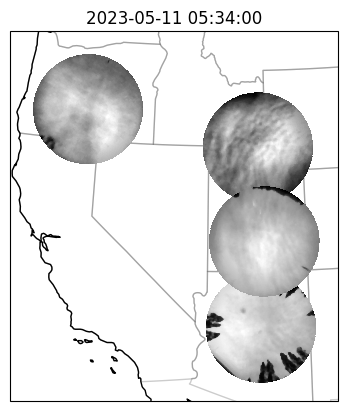

In [17]:
from cartopy import crs,feature

# We will plot images closest to a specific time
target_time = np.datetime64('2023-05-11T05:34:00.000000000')

extent=[-124,-102,30,48]
fig = plt.figure()
axes00 = fig.add_subplot(projection=crs.Orthographic(np.nanmean(extent[:2]),np.nanmean(extent[2:])))
axes00.add_feature(feature.COASTLINE)
axes00.add_feature(feature.STATES,alpha=0.2,zorder=1)

for k in ds.keys():
    nearest_time = ds[k].sel(time=target_time, method='nearest')
    time_difference = abs(pd.to_timedelta(nearest_time.time.values - target_time).total_seconds())

    if time_difference < 10:
        data = ds[k].sel(time=target_time, method='nearest')
        
        latitude = data.Latitude
        longitude = data.Longitude
        mask = data.Elevation > 20.

        pc = axes00.pcolormesh(longitude,latitude,data.ImageData.where(mask),transform=crs.PlateCarree(),cmap='gray')

axes00.set_title(pd.to_datetime(str(target_time)))

In [19]:
# Let's filter the data and plot it
for s in ds.keys():
    # ds[s] = parallel_filter(ds[s], 'ImageData')
    filtered_data = signal.filtfilt(fir_coeff, 1.0, ds[s].ImageData, axis=0)
    ds[s]['FilteredImageData'] = (('time','north','east'), filtered_data)

Text(0.5, 1.0, '2023-05-11 05:34:00')

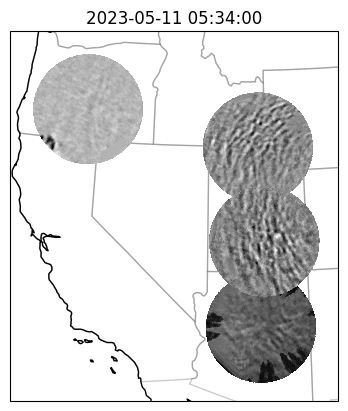

In [20]:
from cartopy import crs,feature

# We will plot images closest to a specific time
target_time = np.datetime64('2023-05-11T05:34:00.000000000')

# Define the map extent (region to be plotted)
extent=[-124,-102,30,48]
fig = plt.figure()
axes00 = fig.add_subplot(projection=crs.Orthographic(np.nanmean(extent[:2]),np.nanmean(extent[2:])))
axes00.add_feature(feature.COASTLINE)
axes00.add_feature(feature.STATES,alpha=0.2,zorder=1)

# Plot the background subtracted image that is closest to the target time (within 10 minutes)
for k in ds.keys():
    nearest_time = ds[k].sel(time=target_time, method='nearest')
    time_difference = abs(pd.to_timedelta(nearest_time.time.values - target_time).total_seconds())

    if time_difference < 10:
        data = ds[k].sel(time=target_time, method='nearest')
        
        latitude = data.Latitude
        longitude = data.Longitude
        mask = data.Elevation > 20.

        background_subtract = data.FilteredImageData - data.FilteredImageData.mean(dim=['east','north'])

        pc = axes00.pcolormesh(longitude,latitude,background_subtract.where(mask),transform=crs.PlateCarree(),cmap='gray')

axes00.set_title(pd.to_datetime(str(target_time)))